In [1]:
import numpy as np
import sympy as sp
import wlcstat.wlc_copoly as wlc_copoly
from scipy.interpolate import interp1d

#FOR VERTEX:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

# TODO:

do 0.9 / 0.1 phase diagrams; 

    - error! look at FA = 0.5 when dopant is FA = 0.5 as well. Should match monodisperse

generalize all functions for n polymer, different lengths

    - for k_star analysis, see if I dont need to apply incompressiblity. 

develop distribution discretization 

# Functions
From the overleaf document "Polydisperse Polymer Field Theory- no averaging" we found that the free energy of a polydisperse system can be broken down into a sum of the contributions from each polymer type, but with $2*n_{poly}$ polymer field fluctutaion terms. This indicates that the free energy calculation procedure for a monodipserse system is highly relevant. 

These binary mix functions were adapted from Vertex codebase by Quinn\Shifan. These functions were for a monodisperse system, where the incompressibility condition $\Delta_A = - \Delta_B$. In the finctions themselves this manifests as multiplying by a negative at certain points in the einstein sum. 
//

For applications to polydisperse systems, this incompressiblity condition does not hold. Therefore, we must first undo this simple, monodisperse incompressiblity condition (apply additional negatives to counteract the condition), then multiply by an array of density fluctutations "dlta" which applies the correct incompressibility condition (the last entry is the negative sum of all previous entries, such that the sum of all entries = 0). 

In [3]:
def spinodal_binary(pset, poly_list, dlta, k_vec = np.logspace(np.log10(1e-1), np.log10(1e1), 100)):
    #this code finds k_Star
    
    #generalized attempt:
    
    #for each polymer
        #build the s2s
        #make the gamma 2 matrix
        #if NOT final polymer:
            # append this matrix diagonally to existing G2
        #if YES final polymer:

            # append AA term diagonally
            
    #####
    #attempt 2 BEST ONE IF DONT NEED TO APPLY INCOMPRESSIBILITY
    
    #for each polymer
        #build the s2s
        #make the gamma 2 matrix
        # append this matrix diagonally to existing G2
        #apply incompressiblity condt
    
    chi = 0
    #Unpack poly_list. TODO: NEED TO GENERALIZE
    FA_1 = poly_list[0][0]
    N_1 = poly_list[0][1]
    PHI_1 = poly_list[0][2]
    
    FA_2 = poly_list[1][0]
    N_2 = poly_list[1][1]
    PHI_2 = poly_list[1][2]
    
    # calculate sfs for a range of ks
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]
    
    # invert sfs
    det_1_arr = s2_AA_1 * s2_BB_1 - s2_AB_1**2
    prefactor_1_arr = 1/(det_1_arr*2*PHI_1)

    det_2_arr = s2_AA_2 * s2_BB_2 - s2_AB_2**2
    prefactor_2_arr = 1/(det_2_arr*2*PHI_2)

    s2inv_AA_1_arr = s2_AA_1*prefactor_1_arr
    s2inv_AB_1_arr = s2_AB_1*prefactor_1_arr
    s2inv_BB_1_arr = s2_BB_1*prefactor_1_arr

    s2inv_AA_2_arr = s2_AA_2*prefactor_2_arr
    s2inv_AB_2_arr = s2_AB_2*prefactor_2_arr
    s2inv_BB_2_arr = s2_BB_2*prefactor_2_arr

    # Construct 4x4 -> 3x3 binary G2 matrix, verctorized. name refers to matrix index TODO: need to generalize

    zero_zero = s2inv_BB_1_arr - (chi*N_1) + s2inv_AA_2_arr
    zero_one = -s2inv_AB_1_arr + s2inv_AA_2_arr
    zero_two = -(chi*N_1) + s2inv_AB_2_arr + s2inv_AA_2_arr

    one_zero = zero_one
    one_one = s2inv_AA_1_arr + s2inv_AA_2_arr
    one_two = s2inv_AB_2_arr + s2inv_AA_2_arr

    two_zero = zero_two
    two_one = one_two
    two_two = s2inv_BB_2_arr + 2*s2inv_AB_2_arr - (chi*N_1) + s2inv_AA_2_arr

    G2 = np.array([zero_zero, zero_one, zero_two, one_zero, one_one, one_two, two_zero, two_one, two_two]).T.reshape(len(k_vec), 3, 3)
    # ^ G2 at a variety of k values
    
    eigvalues,eigvectors = np.linalg.eigh(G2)
    eigvalues_lst = np.concatenate(eigvalues)
    min_eig = np.min(eigvalues_lst)

    k_star = k_vec[np.where(eigvalues_lst==min_eig)[0]//3][0]
    
    return k_star

    #NON VECT- 2min 52 sec
    # VECT - 1min 15 sec

In [4]:
def gamma2binary(pset, K, poly_list, dlta, CHI):
    G = 0
    num_polys = len(poly_list)
    for i, poly in enumerate(poly_list):
        FA = poly[0]
        N = poly[1]
        phi_poly = poly[2]
        
        s2inv = s2inverse(pset, N, FA, K)
        for I0, I1 in product([0,1], repeat=2):
            G += (1/phi_poly)*N*s2inv[I0, I1]* dlta[I0+i*2]*dlta[I1+i*2]  #removed sign indicator -> pre-incompressible
            
    # chi contribution
    i = 0
    while i < num_polys*2:
        j = 1
        while j < num_polys*2:
            G += 2*CHI*(dlta[i]*dlta[j])
            j += 2
        i += 2

#     G += 2*CHI*(dlta[0]*dlta[1] + dlta[0]*dlta[3] + dlta[2]*dlta[1] + dlta[2]*dlta[3]) # hardcoded for binary

    return G

In [5]:
def gamma3binary(pset, Ks, poly_list, dlta):
    #Assuming same N
    #hardcoded DELTA
    #need to return an obe=ejc tthat has 3 different amplitude variables which can be minimized over in scipy
    
    K1, K2, K3 = Ks
    if norm(K1+K2+K3) >= 1e-10:
        raise('Qs must add up to zero')
        
    if not (abs(norm(K1)-norm(K2)) < 1e-5 \
        and abs(norm(K2)-norm(K3)) < 1e-5):
        raise('Qs must have same length')
        
    val = 0
    for i, poly in enumerate(poly_list):
        FA = poly[0]
        N = poly[1]
        phi_poly = poly[2]
        
        s3 = s3wlc(pset, N, FA, Ks)
        s2inv = s2inverse(pset, N, FA, norm(K1))
        for I0, I1, I2 in product([0,1], repeat=3):
            val -= (phi_poly) * s3[I0][I1][I2]* (s2inv[I0][0] - s2inv[I0][1])*\
                                   (s2inv[I1][0] - s2inv[I1][1])*\
                                   (s2inv[I2][0] - s2inv[I2][1])*\
                                    ((-1)**(I0 + I1 + I2))*\
                                    dlta[I0+i*2]*dlta[I1+i*2]*dlta[I2+i*2] 
#     print("G3 N factor: ", N)
    return val*(N**2) 

In [6]:
def gamma4binary(pset, wigset, Ks, poly_list, dlta):
    #Assuming same N
    #hardcoded DELTA
    #need to return an obe=ejc tthat has 3 different amplitude variables which can be minimized over in scipy
    K1, K2, K3, K4 = Ks
    if not (abs(norm(K1)-norm(K2)) < 1e-5
            and abs(norm(K2)-norm(K3)) < 1e-5
            and abs(norm(K3)-norm(K4)) < 1e-5):
        print(K1, K2, K3, K4)
        raise('Qs must have same length')
    
    K = norm(K1)
    K12 = norm(K1+K2)
    K13 = norm(K1+K3)
    K14 = norm(K1+K4)
    
    val = 0
    for i, poly in enumerate(poly_list):
        FA = poly[0]
        N = poly[1]
        phi_poly = poly[2]
    
        s4 = s4wlc(pset, wigset, N, FA, Ks)
        s31 = s3wlc(pset, N, FA, [K1, K2, -K1-K2])
        s32 = s3wlc(pset, N, FA, [K1, K3, -K1-K3])
        s33 = s3wlc(pset, N, FA, [K1, K4, -K1-K4])

        s2inv = s2inverse(pset, N, FA, K)
        s21inv = s2inverse(pset, N, FA, K12)
        s22inv = s2inverse(pset, N, FA, K13)
        s23inv = s2inverse(pset, N, FA, K14)

        G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
        for a1, a2, a3, a4 in product([0,1], repeat=4):
            for I0, I1 in product([0,1], repeat=2):
                G4[a1][a2][a3][a4] += \
                    s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                    s32[a1][a4][I0]*s32[a2][a3][I1]*s22inv[I0][I1] + \
                    s33[a1][a3][I0]*s33[a2][a4][I1]*s23inv[I0][I1]
        G4 -= s4

    #     val = 0
        for I0, I1, I2, I3 in product([0,1], repeat=4):
            val += (phi_poly)*G4[I0][I1][I2][I3] *\
                    (s2inv[I0][0] - s2inv[I0][1])*\
                    (s2inv[I1][0] - s2inv[I1][1])*\
                    (s2inv[I2][0] - s2inv[I2][1])*\
                    (s2inv[I3][0] - s2inv[I3][1])*\
                    (-1)**(I0 + I1 + I2 + I3)*\
                    dlta[I0+i*2]*dlta[I1+i*2]*dlta[I2+i*2]*dlta[I3+i*2]  

#     print("G4 N factor: ", N)
    return val*(N**3)

# Phase diagram comparisons

Want to study this:
N = 10
Fa 1 = 0.3
Fa 2 = 0.5
Phi2 = 0.00001 

VS 

N = 10
Fa 1 = 0.3
Fa 2 = 0.9
Phi2 = 0.00001 


In [7]:
N_1 = 10.
FA_1_arr = np.arange(0.3, 0.701, .1)#np.arange(0.3, 0.701, .025) #np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, .5, 0.6, 0.7, 0.8]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#

PHI_1 = 0.99999#99999999

N_2 = N_1
FA_2 = 0.5
PHI_2 = 0.00001#00000001

if (PHI_1 + PHI_2 > 1.00001) or (PHI_1 + PHI_2 < 1 - .00001):
    raise Exception("Phis dont add up to 1")

# if (PHI_1 < 0.001) or (PHI_2 < 0.001):
#     raise Exception("Phi too low- gamma2 unstable")
chi_array = np.arange(7.5, 15, .1)/N_1

## Free energy calculation

### Monodisperse (Vertex codebase)

In [8]:
N_1

10.0

In [9]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = N_1
fa_array = FA_1_arr

cyl_pnts_vert = np.array([])
lam_pnts_vert = np.array([])
dis_pnts_vert = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs)
    
    lam_g4 = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
       
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
             
        point = np.array([FA, CHI*N])
        
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts_vert = np.append(dis_pnts_vert, point)
        elif (lamF < cylF):
            lam_pnts_vert = np.append(lam_pnts_vert, point) 
        else:
            cyl_pnts_vert = np.append(cyl_pnts_vert, point)
        
    print("one FA done!!")
            

./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):
./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


one FA done!!
one FA done!!
one FA done!!
one FA done!!
one FA done!!
Wall time: 10min 21s


In [10]:
N

10.0

### Polydisperse

In [11]:
# %%time
# # KS comparison code
# sp.var("DEL_A1 DEL_B1 DEL_A2")
# DEL_B2 = -DEL_A1 -DEL_B1 -DEL_A2
# dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

# for FA_1 in FA_1_arr:
#     poly_list = [[FA_1, N_1, PHI_1], [FA_2, N_2, PHI_2]]
#     KS_mono = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
    
#     KS_poly = spinodal_binary(pset, poly_list, dlta, k_vec = np.logspace(np.log10(1e-1), np.log10(1e1), 200))
    
#     print("_________")
#     print("KS_mono: ")
#     print(KS_mono)
#     print("KS_poly: ")
#     print(KS_poly)

In [12]:
%%time
cyl_pnts_poly = np.array([])
lam_pnts_poly = np.array([])
dis_pnts_poly = np.array([])


sp.var("DEL_A1 DEL_B1 DEL_A2")
DEL_B2 = -DEL_A1 -DEL_B1 -DEL_A2
dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

for FA_1 in FA_1_arr:
    poly_list = [[FA_1, N_1, PHI_1], [FA_2, N_2, PHI_2]]
    KS = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
    
#     KS = spinodal_binary(pset, poly_list, dlta)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])

    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])  
    
    
    G3_poly_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3binary(pset, cyl_qs, poly_list, dlta)

    G3_poly_lam = 0
    
    G3lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G3_poly_cyl, 'numpy')

    
    G4p_lam = (1/24) * (6) *gamma4binary(pset, wigset, np.array([lam_q, -lam_q, lam_q, -lam_q]), poly_list, dlta)

    G4p_cyl = (1/12) * (gamma4binary(pset, wigset, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), poly_list, dlta) + \
              4*gamma4binary(pset, wigset, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), poly_list, dlta))

    G4lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_cyl, 'numpy')

    G4lambd_lam = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_lam, 'numpy')
    
    for CHI in chi_array:
        
        G2poly = gamma2binary(pset, q_star, poly_list, dlta, CHI)

        G2lambd = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G2poly, 'numpy')
        
        # amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

#         amp_poly_cyl = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])+ G3lambd_cyl(amps[0], amps[1], amps[2])\
#                                                           + G4lambd_cyl(amps[0], amps[1], amps[2])), [0,0,0], disp=False)

#         amp_poly_lam = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])\
#                                                           + G4lambd_lam(amps[0], amps[1], amps[2])), [1,0,0], disp=False)


#         polyF_cyl = G2lambd(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])+ G3lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])\
#                                                       + G4lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])

#         polyF_lam = G2lambd(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])+ G4lambd_lam(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])
        
#         print("pre-optimization")
        polyF_cyl_obj = optimize.basinhopping(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])+ G3lambd_cyl(amps[0], amps[1], amps[2])\
                                                  + G4lambd_cyl(amps[0], amps[1], amps[2])),[0,0,0],niter=100)
        polyF_cyl = polyF_cyl_obj.fun
        
#         print("completed one optimization")
        polyF_lam_obj = optimize.basinhopping(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])\
                                                           + G4lambd_lam(amps[0], amps[1], amps[2])),[0,0,0],niter=100)
        polyF_lam = polyF_lam_obj.fun
        
        
        point = np.array([FA_1, CHI*N_1])
        
        if (polyF_lam == 0 and polyF_cyl == 0):
            #disordered stable
            dis_pnts_poly = np.append(dis_pnts_poly, point)
        elif (polyF_lam < polyF_cyl):
            lam_pnts_poly = np.append(lam_pnts_poly, point) 
        else:
            cyl_pnts_poly = np.append(cyl_pnts_poly, point)
            
    print("one FA done!")

one FA done!


./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


one FA done!


./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


one FA done!


./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


one FA done!


./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


one FA done!
Wall time: 41min 37s


## Generate interpolation functions

In [13]:
# phase_list = np.array([dis_pnts_vert, lam_pnts_vert, cyl_pnts, gyr_pnts, sq_cyl_pnts])
phase_list = np.array([dis_pnts_vert, lam_pnts_vert])


max_dis_pnts_vert = np.array([])
min_dis_pnts_vert = np.array([])
max_lam_pnts_vert = np.array([])
min_lam_pnts_vert = np.array([])
max_cyl_pnts = np.array([])
min_cyl_pnts = np.array([])
max_sq_cyl_pnts = np.array([])
min_sq_cyl_pnts = np.array([])

for i, phse in enumerate(phase_list):
    phse_x = phse[::2]
    phse_y = phse[1::2]
    
    new_phase_pnt_arr_maxs = np.array([])
    new_phase_pnt_arr_mins = np.array([])

    for fa_val in fa_array:
        min_pnt = []
        max_pnt = []
        same_fa_y_vals = np.array([])
        for j, phx in enumerate(phse_x):
            
            if phx == fa_val:
#                 print("allowed fa", fa_val)
                same_fa_y_vals = np.append(same_fa_y_vals, phse_y[j])
        
        if len(same_fa_y_vals) != 0:
            min_pnt = [fa_val, min(same_fa_y_vals)]
            max_pnt = [fa_val, max(same_fa_y_vals)]
        
        new_phase_pnt_arr_mins = np.append(new_phase_pnt_arr_mins, min_pnt)
        new_phase_pnt_arr_maxs = np.append(new_phase_pnt_arr_maxs, max_pnt)
    
    
    if i == 0:
        max_dis_pnts_vert = new_phase_pnt_arr_maxs
        min_dis_pnts_vert = new_phase_pnt_arr_mins
    elif i == 1:
        max_lam_pnts_vert = new_phase_pnt_arr_maxs
        min_lam_pnts_vert = new_phase_pnt_arr_mins
    elif i == 2:
        max_cyl_pnts = new_phase_pnt_arr_maxs
        min_cyl_pnts = new_phase_pnt_arr_mins
    elif i == 3:
        max_min_gyr_pnts = np.append(new_phase_pnt_arr_mins, new_phase_pnt_arr_maxs)
    elif i == 4:
        max_sq_cyl_pnts = new_phase_pnt_arr_maxs
        min_sq_cyl_pnts = new_phase_pnt_arr_mins

    #get array of all XNs at that fa
    #find max an min
    #return those two points
    #get all x values
    #for all fas, see if present for each phase.
    #if multple ponts in one fa for one phase, find min and max XN points

<ipython-input-13-20434113bbe5>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  phase_list = np.array([dis_pnts_vert, lam_pnts_vert])


In [14]:
# phase_list = np.array([dis_pnts_poly, lam_pnts_poly, cyl_pnts, gyr_pnts, sq_cyl_pnts])
phase_list = np.array([dis_pnts_poly, lam_pnts_poly])

max_dis_pnts_poly = np.array([])
min_dis_pnts_poly = np.array([])
max_lam_pnts_poly = np.array([])
min_lam_pnts_poly = np.array([])
max_cyl_pnts = np.array([])
min_cyl_pnts = np.array([])
max_sq_cyl_pnts = np.array([])
min_sq_cyl_pnts = np.array([])

for i, phse in enumerate(phase_list):
    phse_x = phse[::2]
    phse_y = phse[1::2]
    
    new_phase_pnt_arr_maxs = np.array([])
    new_phase_pnt_arr_mins = np.array([])

    for fa_val in fa_array:
        min_pnt = []
        max_pnt = []
        same_fa_y_vals = np.array([])
        for j, phx in enumerate(phse_x):
            
            if phx == fa_val:
#                 print("allowed fa", fa_val)
                same_fa_y_vals = np.append(same_fa_y_vals, phse_y[j])
        
        if len(same_fa_y_vals) != 0:
            min_pnt = [fa_val, min(same_fa_y_vals)]
            max_pnt = [fa_val, max(same_fa_y_vals)]
        
        new_phase_pnt_arr_mins = np.append(new_phase_pnt_arr_mins, min_pnt)
        new_phase_pnt_arr_maxs = np.append(new_phase_pnt_arr_maxs, max_pnt)
    
    
    if i == 0:
        max_dis_pnts_poly = new_phase_pnt_arr_maxs
        min_dis_pnts_poly = new_phase_pnt_arr_mins
    elif i == 1:
        max_lam_pnts_poly = new_phase_pnt_arr_maxs
        min_lam_pnts_poly = new_phase_pnt_arr_mins
    elif i == 2:
        max_cyl_pnts = new_phase_pnt_arr_maxs
        min_cyl_pnts = new_phase_pnt_arr_mins
    elif i == 3:
        max_min_gyr_pnts = np.append(new_phase_pnt_arr_mins, new_phase_pnt_arr_maxs)
    elif i == 4:
        max_sq_cyl_pnts = new_phase_pnt_arr_maxs
        min_sq_cyl_pnts = new_phase_pnt_arr_mins
    

    #get array of all XNs at that fa
    #find max an min
    #return those two points
    #get all x values
    #for all fas, see if present for each phase.
    #if multple ponts in one fa for one phase, find min and max XN points

<ipython-input-14-f7a99da38b6e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  phase_list = np.array([dis_pnts_poly, lam_pnts_poly])


In [15]:
# #one for lamellar, one for disorderd. the lamellar minimum defines cylidnrical upper bound
# laminterp_vert = interp1d(min_lam_pnts_vert[::2], min_lam_pnts_vert[1::2], kind="quadratic") 
# disinterp_vert = interp1d(max_dis_pnts_vert[::2], max_dis_pnts_vert[1::2], kind="quadratic") 

In [16]:
# #one for lamellar, one for disorderd
# laminterp_poly = interp1d(min_lam_pnts_poly[::2], min_lam_pnts_poly[1::2], kind="quadratic") 
# disinterp_poly = interp1d(max_dis_pnts_poly[::2], max_dis_pnts_poly[1::2], kind="quadratic") 

## Plot

Text(0.5, 1.0, 'Binary mix N = 10.0, $f_A^{\\ (2)}$ = 0.5, $\\phi_2$ = 1e-05 (exact result)')

<Figure size 432x288 with 0 Axes>

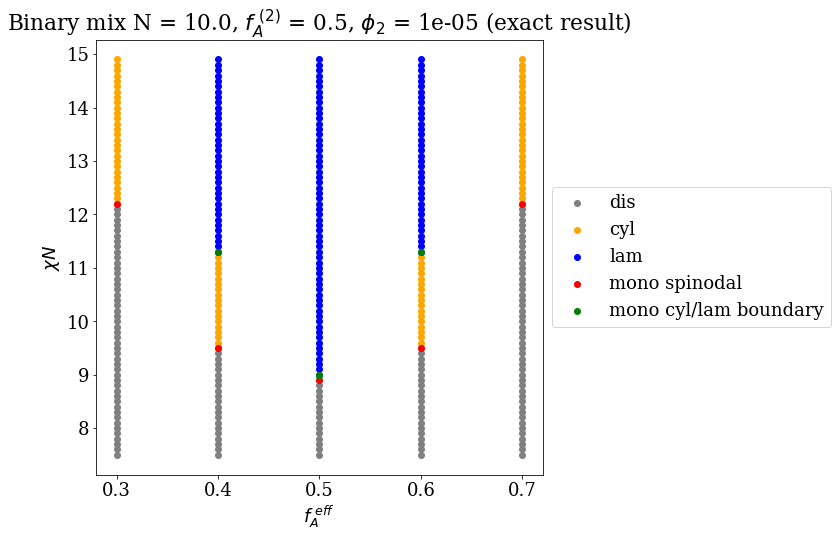

In [17]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


new_x = np.arange(0.301, 0.7, 0.001)
new_x_lam = np.arange(0.4, 0.6, 0.001)

fa_eff = PHI_1 * new_x + PHI_2 * FA_2
fa_eff_lam = PHI_1 * new_x_lam + PHI_2 * FA_2


ax.scatter(dis_pnts_poly[::2], dis_pnts_poly[1::2], label = "dis", color = "grey")
ax.scatter(cyl_pnts_poly[::2], cyl_pnts_poly[1::2], label = "cyl", color = "orange")
ax.scatter(lam_pnts_poly[::2], lam_pnts_poly[1::2], label = "lam", color = "blue")

ax.scatter(max_dis_pnts_vert[::2], max_dis_pnts_vert[1::2], label = "mono spinodal", color = "red")
ax.scatter(min_lam_pnts_vert[::2], min_lam_pnts_vert[1::2], label = "mono cyl/lam boundary", color = "green")

# ax.scatter(dis_pnts_vert[::2], dis_pnts_vert[1::2], label = "dis", color = "grey")
# ax.scatter(lam_pnts_vert[::2], lam_pnts_vert[1::2], label = "mono lam", color = "purple")
# ax.scatter(cyl_pnts_vert[::2], cyl_pnts_vert[1::2], label = "cyl", color = "yellow")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\  eff}$")
ax.set_title("Binary mix N = " + str(N_1) + ", $f_A^{\ (2)}$ = " +  str(np.round(FA_2, 2)) +  ", $\phi_2$ = " +str(np.round(1 - PHI_1, 8)) + " (exact result)")

In [ ]:

# ax.plot(fa_eff_lam, laminterp_poly(new_x_lam), color = "blue",linewidth = 1, label = "lam (mix)")#, linestyle = "dotted")#"lam, $\phi^{(dop)}_P = 0.1$")
# ax.plot(fa_eff, disinterp_poly(new_x), color = "orange", linewidth = 1, label = "cyl (mix)")#), linestyle = "dotted")#"cyl, $\phi^{(dop)}_P = 0.1$")

# ax.plot(new_x_lam, laminterp_vert(new_x_lam), color = "blue",alpha =0.5 , linestyle = "dashed", label = "lam (mono)")#"lam, $\phi^{(dop)}_P = 0.0$") #mono lam
# ax.plot(new_x, disinterp_vert(new_x), color = "orange", alpha = 0.5, linestyle = "dashed", label = "cyl (mono)")#"cyl, $\phi^{(dop)}_P = 0.0$") #mono cyl

# ax.scatter(max_dis_pnts_poly[::2], max_dis_pnts_poly[1::2], label = "dis", color = "orange")
# ax.scatter(min_lam_pnts_poly[::2], min_lam_pnts_poly[1::2],color = "blue")

# ax.scatter(max_dis_pnts_vert[::2], max_dis_pnts_vert[1::2], label = "dis", color = "red")
# ax.scatter(min_lam_pnts_vert[::2], min_lam_pnts_vert[1::2],color = "purple")

### Alternative application of incompressiblity test; monodisperse

Want to see if the alternative way of applying incompressibility affects the phase diagram of a monodisperse ensemble

In [ ]:
#monodisperse alt ways of applying incompressibility:
delta_mono = [DEL_A1, -DEL_A1]

In [ ]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = N_1
fa_array = FA_1_arr

cyl_pnts_altinc = np.array([])
lam_pnts_altinc = np.array([])
dis_pnts_altinc = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    

    G3_mono_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_M(pset, N, FA, cyl_qs, delta_mono)

    G3_mono_lam = 0
    

    G4m_lam = (1/24) * (6) *gamma4_M(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]), delta_mono)

    G4m_cyl = (1/12) * (gamma4_M(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), delta_mono) + \
              4*gamma4_M(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), delta_mono))
    
    G3lambd_cyl_M = sp.lambdify([DEL_A1], G3_mono_cyl, 'numpy')

    G4lambd_cyl_M = sp.lambdify([DEL_A1], G4m_cyl, 'numpy')

    G4lambd_lam_M = sp.lambdify([DEL_A1], G4m_lam, 'numpy')
    
    for CHI in chi_array:
        
        G2mono = gamma2_M(pset, N, FA, k_vec, CHI, delta_mono)
        
        G2lambd_M = sp.lambdify([DEL_A1], G2mono, 'numpy')

        
        
        amp_cyl = optimize.fmin(lambda amps: np.real(G2lambd_M(amps)+ G3lambd_cyl_M(amps) + G4lambd_cyl_M(amps)), 1, disp=False)

        amp_lam = optimize.fmin(lambda amps: np.real(G2lambd_M(amps[0]) + G4lambd_lam_M(amps[0])), [1], disp=False)


        cylF = G2lambd_M(amp_cyl[0]) + G3lambd_cyl_M(amp_cyl[0]) + G4lambd_cyl_M(amp_cyl[0])

        lamF = G2lambd_M(amp_lam[0]) + G4lambd_lam_M(amp_lam[0])
             
        point = np.array([FA, CHI*N])
        
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts_altinc = np.append(dis_pnts_altinc, point)
        elif (lamF < cylF):
            lam_pnts_altinc = np.append(lam_pnts_altinc, point) 
        else:
            cyl_pnts_altinc = np.append(cyl_pnts_altinc, point)

            
    print("one FA done!!")
            

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.301, 0.7, 0.001)
new_x_lam = np.arange(0.4, 0.6, 0.001)

fa_eff = PHI_1 * new_x + PHI_2 * FA_2
fa_eff_lam = PHI_1 * new_x_lam + PHI_2 * FA_2


ax.scatter(dis_pnts_altinc[::2], dis_pnts_altinc[1::2], label = "dis", color = "grey")
ax.scatter(cyl_pnts_altinc[::2], cyl_pnts_altinc[1::2], label = "cyl", color = "orange")
ax.scatter(lam_pnts_altinc[::2], lam_pnts_altinc[1::2], label = "lam", color = "blue")

ax.plot(max_dis_pnts_vert[::2], max_dis_pnts_vert[1::2], label = "mono spinodal", color = "red")
ax.plot(min_lam_pnts_vert[::2], min_lam_pnts_vert[1::2], label = "mono cyl/lam boundary", color = "green")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\  eff}$")
ax.set_title("Monodisperse alt incompressibility condition (adapted vertex)")

### Incompressiblity test- importance for identifying kstar?

In [ ]:
# test- is incompressibilty condition important for k_star analysis. If not, greatly simplifies k_star generalization!!
# monodisperse 1x1 (vertex codebase) vs 2x2 analysis

FA_arr = np.arange(0.3, 0.71, 0.1)

def spinodal_nonincp(N_1, FA_1, k_vec = np.logspace(np.log10(1e-1), np.log10(1e1), 100)):
    
    #TODO: use vertex codebase functions
    chi = 0

    # calculate sfs for a range of ks
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    # invert sfs
    det_1_arr = s2_AA_1 * s2_BB_1 - s2_AB_1**2
    prefactor_1_arr = 1/(det_1_arr*2*PHI_1)
    
    s2inv_AA_1_arr = s2_AA_1*prefactor_1_arr
    s2inv_AB_1_arr = s2_AB_1*prefactor_1_arr
    s2inv_BB_1_arr = s2_BB_1*prefactor_1_arr
    
    G2 = (1/N_1)*np.array([[s2inv_BB_1_arr, -s2inv_AB_1_arr + 0.5*chi*N_1],[-s2inv_AB_1_arr + 0.5*chi*N_1, s2inv_AA_1_arr]]).T.reshape(len(k_vec), 2, 2)#single poly type
    print(G2[0])
    eigvalues,eigvectors = np.linalg.eigh(G2)
    eigvalues_lst = np.concatenate(eigvalues)
    min_eig = np.min(eigvalues_lst)

    k_star = k_vec[np.where(eigvalues_lst==min_eig)[0]//2][0]
    return k_star

In [ ]:
FA = 0.5

In [ ]:
%%time
KS = spinodal(pset, N, FA)
KS

In [ ]:
%%time
spinodal_nonincp(N, FA)

## Single-point free energy calculations

In [ ]:
N_1 = 10.
# FA_1_arr = np.arange(0.3, 0.701, .1) #np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, .5, 0.6, 0.7, 0.8]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#
FA_1 = 0.4
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.9
PHI_2 = 0.00001

poly_list = [[FA_1, N_1, PHI_1], [FA_2, N_2, PHI_2]]
dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

KS = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
q_star = KS[0]

k_vec = KS
k_ind = 0

lam_q = q_star*np.array([1, 0, 0])

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

CHI = 10.40/N_1

monodisp_FA_arr = np.arange(0.3, 0.701, 0.1)

if (PHI_1 + PHI_2 > 1.00001) or (PHI_1 + PHI_2 < 1 - .00001):
    raise Exception("Phis dont add up to 1")

In [ ]:
%%time
G2poly = gamma2binary(pset, k_vec, poly_list, dlta, CHI)


G3_poly_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3binary(pset, cyl_qs, poly_list, dlta)

G3_poly_lam = 0


G4p_lam = (1/24) * (6) *gamma4binary(pset, wigset, np.array([lam_q, -lam_q, lam_q, -lam_q]), poly_list, dlta)

G4p_cyl = (1/12) * (gamma4binary(pset, wigset, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), poly_list, dlta) + \
          4*gamma4binary(pset, wigset, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), poly_list, dlta))


G2lambd = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G2poly, 'numpy')

G3lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G3_poly_cyl, 'numpy')

G4lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_cyl, 'numpy')

G4lambd_lam = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_lam, 'numpy')

In [ ]:
%%time
# amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

amp_poly_cyl = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2]) + G3lambd_cyl(amps[0], amps[1], amps[2])\
                                                  + G4lambd_cyl(amps[0], amps[1], amps[2])), [1,1,1], disp=False)

amp_poly_lam = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])\
                                                  + G4lambd_lam(amps[0], amps[1], amps[2])), [1,1,1], disp=False)


polyF_cyl = G2lambd(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2]) + G3lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])\
                                              + G4lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])

polyF_lam = G2lambd(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2]) + G4lambd_lam(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])

In [ ]:
polyF_cyl

In [ ]:
polyF_lam

In [ ]:
polyF_lam < polyF_cyl

### Re-applying incompressibility test on a Monodisperse system

The goal here is to undo incompressibility in base Vertex functions (appliying -1s correctly), then re-apply it with a delta array that has the condition applied, ALL FOR A MONODISPERSE SYSTEM. Should get exact same results as original Vertex codebase.

In [ ]:
#check if approach works for monodisperse

#for each func, need to remove incompressiblity condition and add dels which enforce incompressibilty
def gamma2_M(pset, N, FA, K, CHI, dlta):
    s2inv = s2inverse(pset, N, FA, K)

#     D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += N*s2inv[I0, I1]*dlta[I0]*dlta[I1] #removed sign indicator
    
    G += 2*CHI*(dlta[0]*dlta[1])
    return G#-2*CHI + N*G

def gamma3_M(pset, N, FA, Ks, dlta):
    K1, K2, K3 = Ks
    if norm(K1+K2+K3) >= 1e-10:
        raise('Qs must add up to zero')
        
    if not (abs(norm(K1)-norm(K2)) < 1e-5 \
        and abs(norm(K2)-norm(K3)) < 1e-5):
        raise('Qs must have same length')
    
    s3 = s3wlc(pset, N, FA, Ks)
    s2inv = s2inverse(pset, N, FA, norm(K1))
    
    val = 0
    for I0, I1, I2 in product([0,1], repeat=3):
        #should always be positive del cubed
#         print("---------")
#         print("I0 = " + str(I0) + " I1 = " + str(I1) + " I2 = " + str(I2))
#         print("delta1 = " + str(dlta[I0]) + "delta1 = " + str(dlta[I1]) + "delta1 = " + str(dlta[I2]))
#         print(((-1)**(I0 + I1 + I2))*dlta[I0]*dlta[I1]*dlta[I2])
        val -= s3[I0][I1][I2]* (s2inv[I0][0] - s2inv[I0][1])*\
                               (s2inv[I1][0] - s2inv[I1][1])*\
                               (s2inv[I2][0] - s2inv[I2][1])*\
                                    ((-1)**(I0 + I1 + I2))*\
                                    dlta[I0]*dlta[I1]*dlta[I2] 

    return val*(N**2)

def gamma4_M(pset, wigset, N, FA, Ks, dlta):
    K1, K2, K3, K4 = Ks
    if not (abs(norm(K1)-norm(K2)) < 1e-5
            and abs(norm(K2)-norm(K3)) < 1e-5
            and abs(norm(K3)-norm(K4)) < 1e-5):
        print(K1, K2, K3, K4)
        raise('Qs must have same length')
    
    K = norm(K1)
    K12 = norm(K1+K2)
    K13 = norm(K1+K3)
    K14 = norm(K1+K4)
    
    s4 = s4wlc(pset, wigset, N, FA, Ks)
    s31 = s3wlc(pset, N, FA, [K1, K2, -K1-K2])
    s32 = s3wlc(pset, N, FA, [K1, K3, -K1-K3])
    s33 = s3wlc(pset, N, FA, [K1, K4, -K1-K4])

    s2inv = s2inverse(pset, N, FA, K)
    s21inv = s2inverse(pset, N, FA, K12)
    s22inv = s2inverse(pset, N, FA, K13)
    s23inv = s2inverse(pset, N, FA, K14)

    G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    for a1, a2, a3, a4 in product([0,1], repeat=4):
        for I0, I1 in product([0,1], repeat=2):
            G4[a1][a2][a3][a4] += \
                s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                s32[a1][a4][I0]*s32[a2][a3][I1]*s22inv[I0][I1] + \
                s33[a1][a3][I0]*s33[a2][a4][I1]*s23inv[I0][I1]
    G4 -= s4
    
    val = 0
    for I0, I1, I2, I3 in product([0,1], repeat=4):
        val += G4[I0][I1][I2][I3] *\
                (s2inv[I0][0] - s2inv[I0][1])*\
                (s2inv[I1][0] - s2inv[I1][1])*\
                (s2inv[I2][0] - s2inv[I2][1])*\
                (s2inv[I3][0] - s2inv[I3][1])*\
                ((-1)**(I0 + I1 + I2 + I3))*\
                dlta[I0]*dlta[I1]*dlta[I2]*dlta[I3]  
                
    return val*(N**3)

In [ ]:
N_1 = 10.
# FA_1_arr = p.arange(0.3, 0.701, .1) #np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, .5, 0.6, 0.7, 0.8]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#
FA_1 = 0.3

dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

KS = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
q_star = KS[0]

k_vec = KS
k_ind = 0

lam_q = q_star*np.array([1, 0, 0])

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

CHI = 25/N_1

In [ ]:
delta_mono = [DEL_A1, -1 * DEL_A1]

In [ ]:
G2mono = gamma2_M(pset, N_1, FA_1, k_vec, CHI, delta_mono)


G3_mono_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_M(pset, N_1, FA_1, cyl_qs, delta_mono)

G3_mono_lam = 0


G4m_lam = (1/24) * (6) *gamma4_M(pset, wigset, N_1, FA_1, np.array([lam_q, -lam_q, lam_q, -lam_q]), delta_mono)

G4m_cyl = (1/12) * (gamma4_M(pset, wigset, N_1, FA_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), delta_mono) + \
          4*gamma4_M(pset, wigset, N_1, FA_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), delta_mono))


G2lambd_M = sp.lambdify([DEL_A1], G2mono, 'numpy')

G3lambd_cyl_M = sp.lambdify([DEL_A1], G3_mono_cyl, 'numpy')

G4lambd_cyl_M = sp.lambdify([DEL_A1], G4m_cyl, 'numpy')

G4lambd_lam_M = sp.lambdify([DEL_A1], G4m_lam, 'numpy')

In [ ]:
# amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

amp_cyl = optimize.fmin(lambda amps: np.real(G2lambd_M(amps)+ G3lambd_cyl_M(amps) + G4lambd_cyl_M(amps)), 1, disp=False)

amp_lam = optimize.fmin(lambda amps: np.real(G2lambd_M(amps[0]) + G4lambd_lam_M(amps[0])), [1], disp=False)


mine_monoF_cyl = G2lambd_M(amp_cyl[0]) + G3lambd_cyl_M(amp_cyl[0]) + G4lambd_cyl_M(amp_cyl[0])

mine_monoF_lam = G2lambd_M(amp_lam[0]) + G4lambd_lam_M(amp_lam[0])

In [ ]:
%%time
#single component G2 matrix stability analysis, POST INCOMPRESSIBILITY 

G2vert = gamma2(pset, N_1, FA_1, q_star, CHI)

G3vert_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N_1, FA_1, cyl_qs) 
G4vert_cyl = (1/12)* (gamma4(pset, wigset, N_1, FA_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
          4*gamma4(pset, wigset, N_1, FA_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))

G3vert_lam = 0
G4vert_lam = (1/24) * (6) * (1) * gamma4(pset, wigset, N_1, FA_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))

amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * G2vert + amps**3 * G3vert_cyl + amps**4 * G4vert_cyl), \
                      1, disp=False)

amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * G2vert + amps**3 * G3vert_lam + amps**4 * G4vert_lam), \
                      1, disp=False)

vert_cylF = amp_c1**2 * G2vert + amp_c1**3 * G3vert_cyl + amp_c1**4 * G4vert_cyl

vert_lamF = amp_l1**2 * G2vert + amp_l1**3 * G3vert_lam + amp_l1**4 * G4vert_lam

In [ ]:
vert_cylF

In [ ]:
vert_lamF

In [ ]:
mine_monoF_lam

In [ ]:
mine_monoF_cyl

In [ ]:
# amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

G2mono = gamma2_M(pset, N_1, FA_1, k_vec, CHI, delta_mono)
G2lambd_M = sp.lambdify([DEL_A1], G2mono, 'numpy')

G3_mono_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_M(pset, N_1, FA_1, cyl_qs, delta_mono)
G3lambd_cyl_M = sp.lambdify([DEL_A1], G3_mono_cyl, 'numpy')

amp_mine = optimize.fmin(lambda amps: np.real(G2lambd_M(amps) + G3lambd_cyl_M(amps)), 1, disp=False)
monoF_mine = G2lambd_M(amp_mine) + G3lambd_cyl_M(amp_mine)

In [ ]:
G2vert = gamma2(pset, N_1, FA_1, k_vec, CHI)
G3vert_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N_1, FA_1, cyl_qs)

amp_vert = optimize.fmin(lambda amp: np.real(amp**2 * G2vert + amp**3 * G3vert_cyl), 1, disp=False)
Fvert = amp_vert**2 * G2vert + amp_vert**3 * G3vert_cyl

In [ ]:
Fvert

In [ ]:
monoF_mine

In [ ]:
G3quinn = gamma3(pset, N_1, FA_1, cyl_qs)

In [ ]:
G3quinn

In [ ]:
(-1)**0

In [ ]:
G3mebaby = gamma3_M(pset, N_1, FA_1, cyl_qs, delta_mono)

In [ ]:
sp.simplify(G3mebaby)

In [ ]:
#G2 matches exactly!!
#test g3, g4
21.308914/4.7170954